The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class1D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class1D/_data_temp/convergence_analysis3/
The MFI grid was: 
xmin= -6.0  xmax= 6.0  nx= 501

The new PLUMED grid is: 
pl_xmin= -7.01  pl_xmax= 7.01  pl_nx= 585


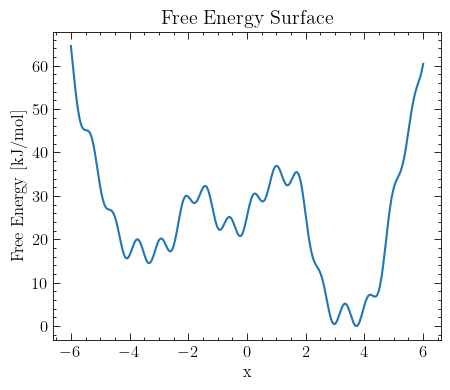

In [43]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib1D as lib1
import MFI_class1D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_temp/convergence_analysis3/"): print("\nThe data folder \"_data_temp/convergence_analysis3/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_temp/convergence_analysis3/"); 
    path_data = path_notebook + "/_data_temp/convergence_analysis3/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


# Load the grid, the FES, and the PLUMED grid. Change n_surf to select the surface.  
for _surf_parameters_ in [0]:
    [grid, y_list, y_string_list] = lib1.load_pkl(path_notebook + "/fes_list_1D")
    FES_cutoff_list = [30, 40, 50, 50, 50, 70, 60, 60, 70, 80, 80, 90, 80, 90, 80, 100, 100, 100, 110, 110]
    n_surf = 3
    y = y_list[n_surf]
    FES_cutoff = FES_cutoff_list[n_surf]
    y_string = y_string_list[n_surf]  
    plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x FUNC=({y_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
    dx, dy = grid[1] - grid[0], np.gradient(y, grid[1] - grid[0]) 
    [pl_x, pl_min, pl_max, pl_n, pl_ext] = lib1.get_plumed_grid_1D(grid, -7, 7, print_info=True)
    plt.figure(figsize=(5,4)); plt.plot(grid, y); plt.xlabel("x"); plt.ylabel("Free Energy [kJ/mol]"); plt.title("Free Energy Surface"); plt.show()

#### Define default parameters

In [12]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1); pass

In [2]:
default_params = {	"grid":grid, "y":y, "bw":dx*1.5, "periodic":False, #"dy":dy, # "initial_position":[0,0], 
					"System":"Langevin", "plumed_dat_text":plumed_dat_text, "pl_grid":pl_x, "simulation_steps": 2_000_000, 
					"position_pace":50, "metad_pace":500, "n_pos_per_window":10, 
     				"metad_width":0.1, "metad_height":3, "biasfactor":20 , 
         			"Bias_sf":1.05, "gaus_filter_sigma":1, 
                    "len_error_list":100, 
					"FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":None, "record_forces_e":True, "save_error_progression":True,
     				"simulation_folder_path": path_data, "print_info": False}

### Run Long simulation for reference

In [36]:
# Run 100 long simulations
long_sim_params = {**default_params}

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,33):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class1D.MFI1D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index]
                
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, (AAD at 5% = {aad[5]:.4f})")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")       



Simulation 1 (exists) | Final Error: Aofe = 2.5787, AAD = 0.5152, (AAD at 5% = 14.1960)
Simulation 2 (exists) | Final Error: Aofe = 2.6709, AAD = 0.3434, (AAD at 5% = 0.7817)
Simulation 3 (exists) | Final Error: Aofe = 2.5552, AAD = 0.3716, (AAD at 5% = 13.2588)
Simulation 4 (exists) | Final Error: Aofe = 2.6008, AAD = 0.3678, (AAD at 5% = 1.9541)
Simulation 5 (exists) | Final Error: Aofe = 2.7229, AAD = 0.5155, (AAD at 5% = 1.1444)
--- Mean of final AAD: 0.4227
Simulation 6 (exists) | Final Error: Aofe = 2.6945, AAD = 0.4871, (AAD at 5% = 12.4332)
Simulation 7 (exists) | Final Error: Aofe = 2.6605, AAD = 0.3367, (AAD at 5% = 0.7570)
Simulation 8 (exists) | Final Error: Aofe = 2.5995, AAD = 0.4340, (AAD at 5% = 16.2120)
Simulation 9 (exists) | Final Error: Aofe = 2.7086, AAD = 0.3191, (AAD at 5% = 15.4339)
Simulation 10 (exists) | Final Error: Aofe = 2.6797, AAD = 0.3835, (AAD at 5% = 0.6235)
--- Mean of final AAD: 0.4074
Simulation 11 (exists) | Final Error: Aofe = 2.6273, AAD = 0.279

Mean Final AAD: 0.4052 +- 0.0187


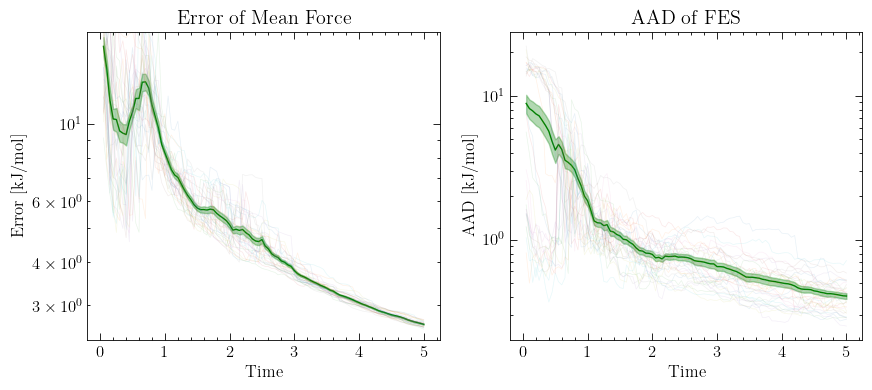

In [19]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f}")
plt.show()


### Exploration simulation

In [6]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":100_000, "metad_height":15, "metad_width":0.1, "biasfactor":200, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(6,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        print(f"{t.shape, aofe.shape, aad.shape}")
        
        # if t.shape == 100, make it 25
        if t.shape[0] == 100:
            t = t[::4]; aofe = aofe[::4]; aad = aad[::4]
            lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class1D.MFI1D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")       


Simulation 6 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.7081, AAD = 8.6257
Simulation 7 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 15.9971, AAD = 6.3708
Simulation 8 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.7561, AAD = 5.0900
Simulation 9 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.1440, AAD = 4.6812
Simulation 10 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.0160, AAD = 4.2586
--- Mean of final AAD: 5.8052
Simulation 11 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.6800, AAD = 4.0103
Simulation 12 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 17.1978, AAD = 3.1523
Simulation 13 (exists) | ((100,), (100,), (100,))
Final Error: Aofe = 16.2039, AAD = 3.8321
Simulation 14 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.2148, AAD = 8.3496
Simulation 15 (exists) | ((25,), (25,), (25,))
Final Error: Aofe = 16.1725, AAD = 7.6172
--- Mean of final AAD: 5.5988
Simulation 16 (exists) | ((25,), (25,), (25,))
Fina

Mean Final AAD: 5.0762 +- 0.1876


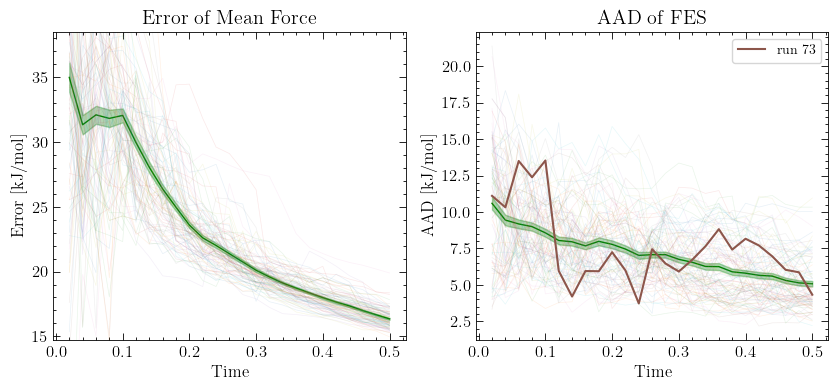

In [10]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

plt.plot(t, aad_collection[73], label="run 73")
plt.legend(fontsize=10)
plt.show()


Final Error: Aofe = 16.2500, AAD = 5.0055
MIN(FES+Bias) = 49.4891, MIN(Z+Bias) = 54.0033


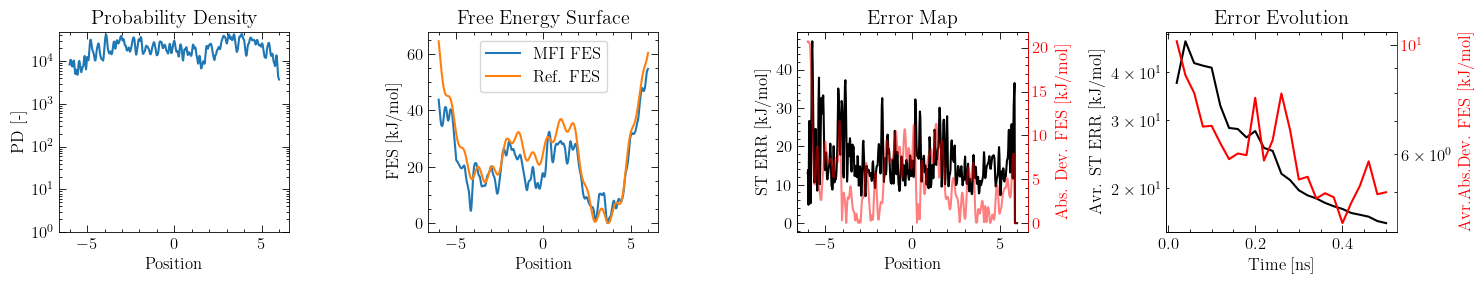

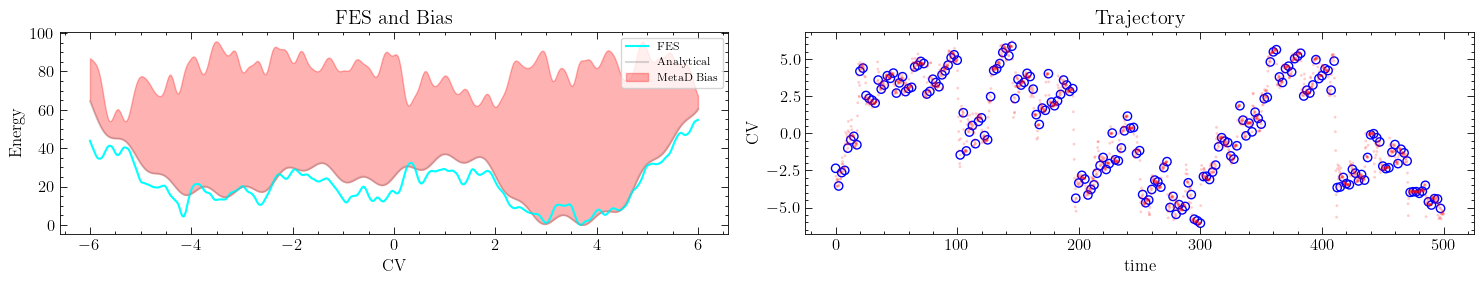

In [11]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
new_params.update({"ID":"_expl_74", "len_error_list":25})

MFI_expl = MFI_class1D.MFI1D(**new_params)
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(MFI_expl.y + MFI_expl.Bias):.4f}")

MFI_expl.plot_results()
lib1.plot_FES_Bias_and_Traj(grid=MFI_expl.grid, fes=MFI_expl.FES, metad_bias=MFI_expl.Bias, position=MFI_expl.position, hills=MFI_expl.hills, y=MFI_expl.y )

t_expl, v_expl, aofe_expl, aad_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES


### 2nd Stage - Run MetaD simulation

In [31]:
print(MFI_long.simulation_steps)
print(MFI_metad.simulation_steps)

print(MFI_long.metad_pace)
print(MFI_metad.metad_pace)

print(MFI_long.position_pace)
print(MFI_metad.position_pace)

print(MFI_long.n_pos)
print(MFI_metad.n_pos)

print(MFI_long.sim_time)
print(MFI_metad.sim_time)


2000000
1900000
500
500
50
50
40000
38000
10.0
9.5


In [25]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":1_900_000, "len_error_list":100, "save_error_progression":True, "save_results":True})#, "n_pos":47_500})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,102):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class1D.MFI1D(**metad_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): 
            MFI_metad.make_external_bias(FES=fes_expl)
            MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")
    if i_sim % 5 == 0: print(f"--- Mean of final AAD: {np.mean(aad_collection, axis=0)[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 1.8258, AAD = 0.3811
Simulation 2 (exists) | Final Error: Aofe = 1.8300, AAD = 0.3249
Simulation 3 (exists) | Final Error: Aofe = 1.8345, AAD = 0.4373
Simulation 4 (exists) | Final Error: Aofe = 1.8283, AAD = 0.5058
Simulation 5 (exists) | Final Error: Aofe = 1.8300, AAD = 0.3249
--- Mean of final AAD: 0.3948
Simulation 6 (exists) | Final Error: Aofe = 1.8099, AAD = 0.4248
Simulation 7 (exists) | Final Error: Aofe = 1.8219, AAD = 0.3349
Simulation 8 (exists) | Final Error: Aofe = 1.8088, AAD = 0.3706
Simulation 9 (exists) | Final Error: Aofe = 1.8052, AAD = 0.4534
Simulation 10 (exists) | Final Error: Aofe = 1.8072, AAD = 0.5468
--- Mean of final AAD: 0.4104
Simulation 11 (exists) | Final Error: Aofe = 1.8242, AAD = 0.4181
Simulation 12 (exists) | Final Error: Aofe = 1.8132, AAD = 0.4635
Simulation 13 (exists) | Final Error: Aofe = 1.8238, AAD = 0.3018
Simulation 14 (exists) | Final Error: Aofe = 1.8307, AAD = 0.3389
Simulation 15 (exists) | 

Mean Final AAD: 0.4477 +- 0.0109


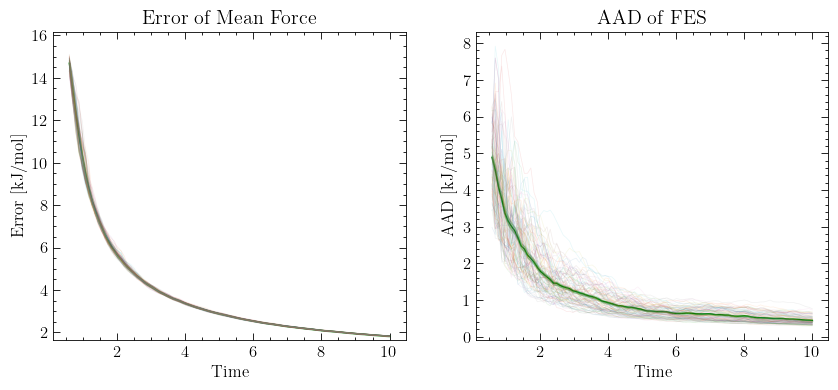

In [22]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f}")
plt.show()

### 2nd Stage - Run 2x MetaD simulations

Time taken for x2 MetaD simulation: 4.9613 sec
Final Error: Aofe=1.2069 AAD=0.1267


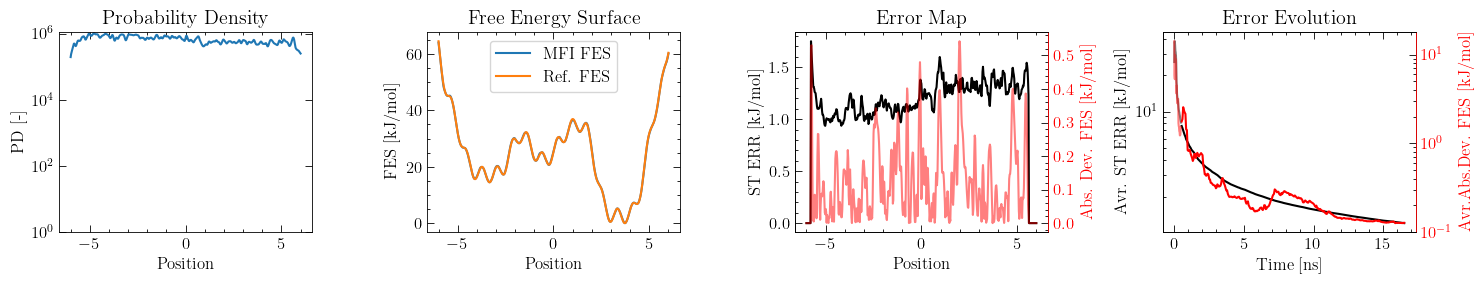

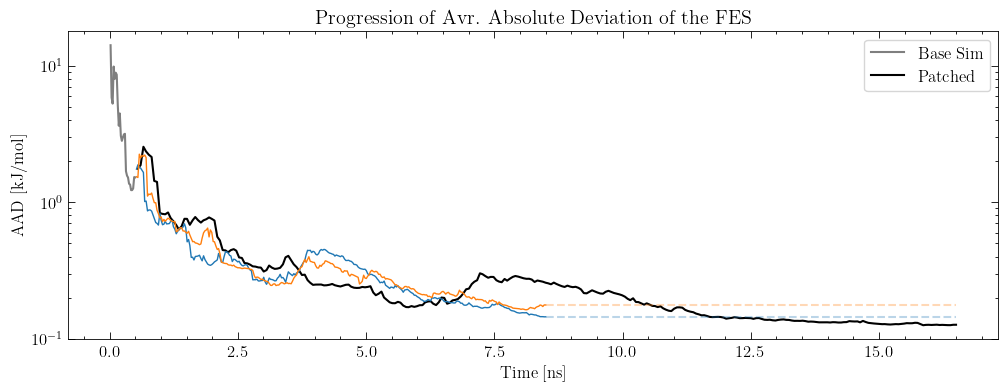

In [106]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class1D.MFI1D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, aofe, aad = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


In [ ]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

### 2nd Stage - Run 3x MetaD simulations

In [102]:
os.chdir(path_notebook); reload(MFI_class1D); reload(lib1);

Time taken for x3 MetaD simulation: 3.5237 sec
Final Error: Aofe=1.0287 AAD=0.1589


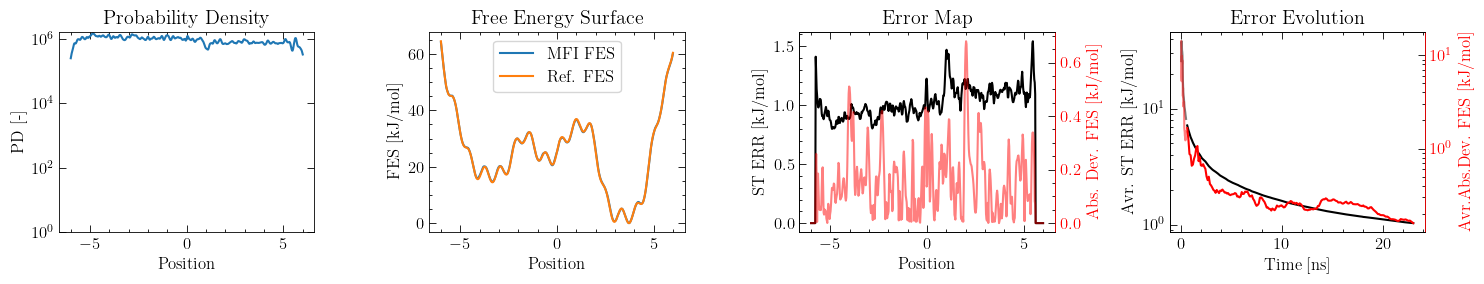

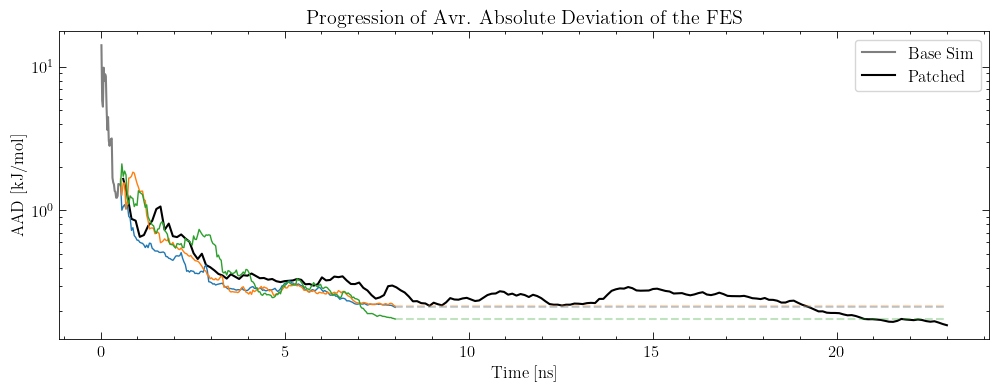

In [105]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class1D.MFI1D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


In [ ]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - Run 4x MetaD simulations

Time taken for x4 MetaD simulation: 3.1549 sec
Final Error: Aofe=0.9172 AAD=0.1602


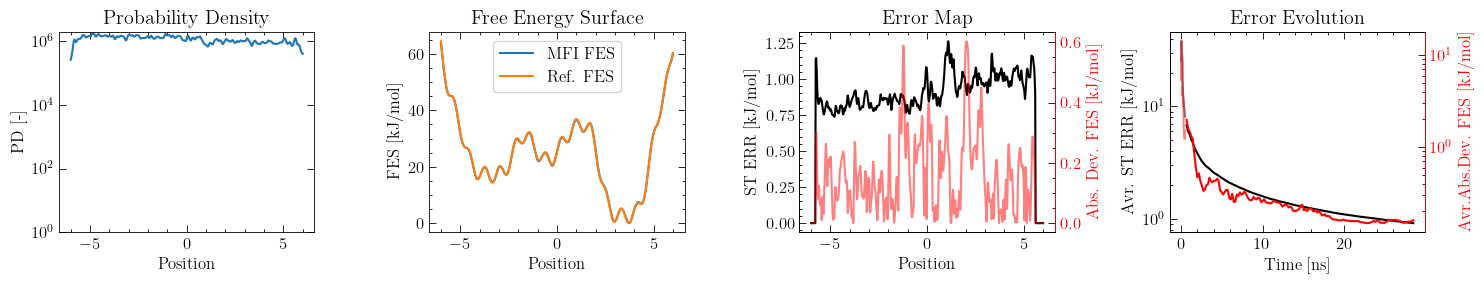

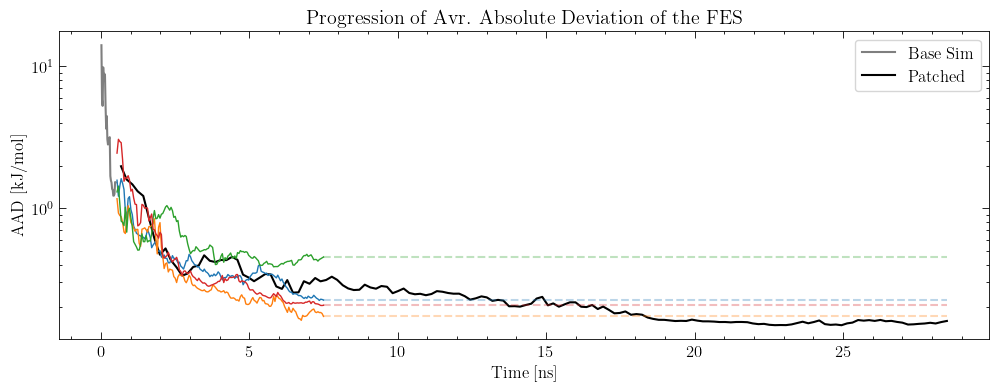

In [110]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class1D.MFI1D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



In [ ]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [ ]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class1D.MFI1D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


In [ ]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [ ]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib1.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class1D.MFI1D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib1.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib1.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


In [ ]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib1.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [16]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    if window_length is None: window_length = int(len(data)/20)
    if polyorder is None: polyorder = 2
    return savgol_filter(data, window_length, polyorder)
    # return data

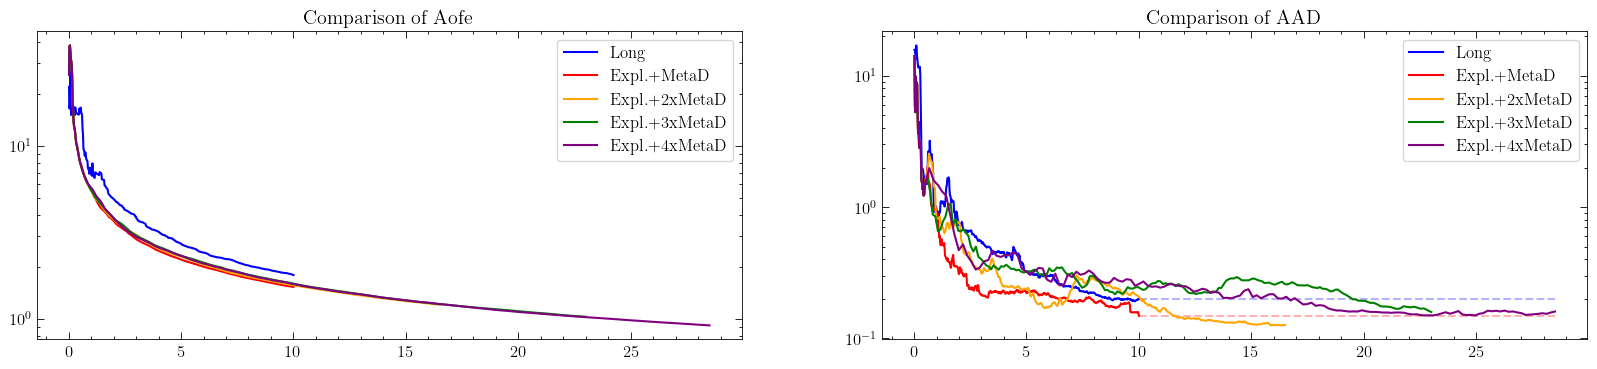

In [111]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx10", color="grey")

plt.ylim(0.38, 3)
plt.xlim(0, 5)
# plt.yscale("log"); 
plt.legend(); plt.title("Comparison of AAD"); plt.show()

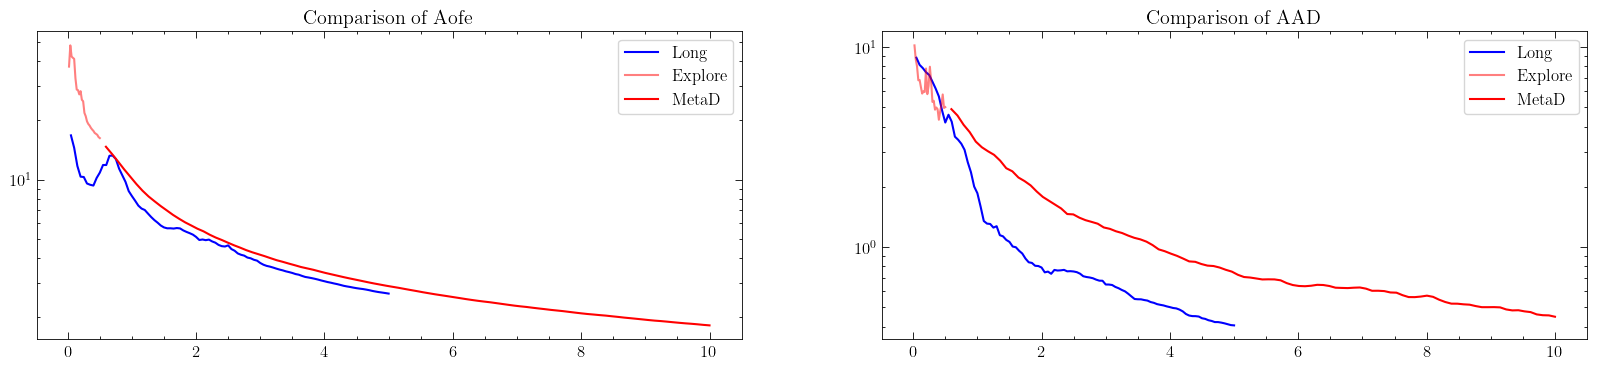

In [47]:
plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,2,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,2,2)
plt.plot(time_long, mean_aad_long, label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_aad_metad, label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, mean_aad_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx3, mean_aad_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_aad_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_aad_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_aad_metadx10, label="MetaDx6", color="grey")

# plt.ylim(0.38, 0.6)
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); plt.show()
